In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pydrake.math import sin, cos

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

from dynamics_nd import get_nd_state, CubeVisualizer, nd_cube_dynamics, ground_distances, corner_x_pos

import time
import random

In [2]:
state = (1,2,3,4,1.0,2.0,3.0,0)
s = get_nd_state(state, 2)
print(s)
print(len(s))

(1, 2, 3, 4, 1.0, 2.0, 3.0, 0)
8


In [3]:
vis = CubeVisualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [13]:
def compute_optimal_control(dim, initial_state, final_state, min_time, max_time, max_torque):

    # state length
    Sl = len(initial_state)
# Setup solver
    mp = MathematicalProgram()

# number knot points
    N = 50
    
# Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
# Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input for the cube
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time
    
# Force decision variables
    f = mp.NewContinuousVariables(8, "f_%d" % 0) # only one input for the cube
    f_over_time = f
    for k in range(1,N):
        f = mp.NewContinuousVariables(8, "f_%d" % k)
        f_over_time = np.vstack((f_over_time, f))
    total_f = f_over_time

# State decision variables
    x = mp.NewContinuousVariables(Sl, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(Sl, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
# State Constraints
    error_thresh = 0.01
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + nd_cube_dynamics(total_x[n,:], dim, total_u[n,:], total_f[n,:])*dt
        
        # Make sure the actual and predicted align to follow dynamics
        for j in range(Sl):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)
            
# Can't penitrate the floor and can't leave the floor
    for n in range(N):
        distances = ground_distances(total_x[n,:], dim)
        
        # the floor is at -.5
        floor_offset = -.01
        mp.AddConstraint(distances[0] >= floor_offset)
        mp.AddConstraint(distances[1] >= floor_offset)
        mp.AddConstraint(distances[2] >= floor_offset)
        mp.AddConstraint(distances[3] >= floor_offset)
        
        # don't leave the ground
        offset = 0.1
        mp.AddConstraint(distances[0] <= np.sqrt(2)+offset)
        mp.AddConstraint(distances[1] <= np.sqrt(2)+offset)
        mp.AddConstraint(distances[2] <= np.sqrt(2)+offset)
        mp.AddConstraint(distances[3] <= np.sqrt(2)+offset)
        
        x_pos = corner_x_pos(total_x[n,:], dim)
        # make left corner on the ground
        mp.AddConstraint(distances[0] == 0.0)
        mp.AddConstraint(x_pos[0] == -0.5)
        
# Ground forces can't pull on the ground
    max_force = 100
    for n in range(N):
        force = total_f[n]
        for j in range(8):
            mp.AddConstraint(force[j] <= max_force)
            mp.AddConstraint(force[j] >= 0)
    
# add complimentary constraint
    for n in range(N):
        force = total_f[n]
        state = total_x[n]
        theta = state[dim]
        
        distances = ground_distances(total_x[n+1,:], dim)
        
        s = sin(theta)
        c = cos(theta)
        
        z_0 = force[0]*c + force[1]*s
        z_1 = - force[2]*s + force[3]*c
        z_2 = - force[4]*c - force[5]*s
        z_3 = force[6]*s - force[7]*c
        
        xy_0 = - force[0]*s + force[1]*c
        xy_1 = - force[2]*c - force[3]*s
        xy_2 = force[4]*s - force[5]*c
        xy_3 = force[6]*c + force[7]*s
        
        mu = 0.1
        
        mp.AddConstraint(xy_0 <= z_0*mu)
        mp.AddConstraint(xy_0 >= -z_0*mu)
        mp.AddConstraint(xy_1 <= z_1*mu)
        mp.AddConstraint(xy_1 >= -z_1*mu)
        mp.AddConstraint(xy_2 <= z_2*mu)
        mp.AddConstraint(xy_2 >= -z_2*mu)
        mp.AddConstraint(xy_3 <= z_3*mu)
        mp.AddConstraint(xy_3 >= -z_3*mu)
        
        
        vector_0 = force[0] * force[1]
        vector_1 = force[2] * force[3]
        vector_2 = force[4] * force[5]
        vector_3 = force[6] * force[7]
        
        val = np.asarray([vector_0, vector_1, vector_2, vector_3])

        thresh = 0.0001
        mp.AddConstraint(val.dot(distances) <= thresh)
        mp.AddConstraint(val.dot(distances) >= -thresh)
    
    
# cost
#     mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))
#     for i in range(8):
#         mp.AddQuadraticCost(1 * f_over_time[:,i].dot(f_over_time[:,i]))


# initial state
    for i in range(Sl):
        # initial
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)

# don't care about final wheel angle
    error_thresh = 0.01
#     v = [0,1,dim,0+Sl/2,1+Sl/2,dim+Sl/2,-1]
    v = [i for i in range(0, Sl)]
    a = v[0:Sl/2-1] + v[Sl/2:]
    for i in a:
        # final
        final_state_error = x_over_time[-1,i] - final_state[i]
        mp.AddConstraint(final_state_error <= error_thresh)
        mp.AddConstraint(final_state_error >= -error_thresh)
        
# make this 2d only
#     for n in range(N):
#         state = total_x[n]
        
#         # y
#         mp.AddConstraint(state[1] == 0)
        
#         # angles
#         mp.AddConstraint(state[3] == 0)
#         mp.AddConstraint(state[5] == 0)
        
#         # velocities
#         mp.AddConstraint(state[10] == 0)
#         mp.AddConstraint(state[12] == 0)
    
# add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
    mp.AddConstraint(time_used[0] <= maximum_time)

# add torque constraints
    for n in range(N):
        mp.AddConstraint(u_over_time[n,0] <= max_torque)
        mp.AddConstraint(u_over_time[n,0] >= -max_torque)
        
        
# set the initial guess
#     x_guess = np.linspace(initial_state[0], final_state[0], N)
#     mp.SetInitialGuess(total_x[:,0], x_guess)
    
#     z_guess = np.linspace(initial_state[2], final_state[2], N)
#     mp.SetInitialGuess(total_x[:,2], z_guess)
    
#     theta_guess = np.linspace(initial_state[4], final_state[4], N)
#     mp.SetInitialGuess(total_x[:,4], theta_guess)
    
#     mp.SetInitialGuess(total_f[4:], np.zeros((4,N)))

# set constraint on velocity sign
#     for n in range(0, N//2):
#         mp.AddConstraint(total_x[n][-1] >= 0.0)
#     for n in range(N//2, N):
#         mp.AddConstraint(total_x[n][-1] <= 0.0)
    
    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    force_trajectory = mp.GetSolution(f_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    return trajectory, input_trajectory, force_trajectory, time_array

In [14]:
m = MathematicalProgram()
m.SetInitialGuessForAllVariables

<bound method MathematicalProgram.SetInitialGuessForAllVariables of <pydrake.solvers._mathematicalprogram_py.MathematicalProgram object at 0x111ee90f0>>

In [15]:
dimension = 3

In [26]:
# Set the inital condititions
x = 0.; y = 0.0; theta = 0.;
origin_1 = get_nd_state((x,y,theta,0,0,0,0,0), dimension)
print(origin_1)

x = 0.0; y = 1.0; theta = 0.;
origin_2 = get_nd_state((x,y,theta,0,0,0,0,0), dimension)
print(origin_2)

x = -0.5; y = .5*(2**.5)-.5; theta = np.pi/4.0;
final_1 = get_nd_state((x,y,theta,0,0,0,0,0), dimension)
print(final_1)

x = 0.5; y = .5*(2**.5)-.5; theta = -np.pi/4.0;
final_2 = (x,y,theta,0,0,0,0,0)

x = -1.0; y = 0.0; theta = np.pi/2.0;
final_3 = get_nd_state((x,y,theta,0,0,0,0,0), dimension)

minimum_time = 0.5; maximum_time = 15.; max_torque = 1000.0


[0.0, 0.0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0.0, 1.0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.5, 0.20710678118654757, 0, 0.7853981633974483, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
len(origin_1)

14

In [28]:
vis.draw_transformation(origin_1, dimension)

In [29]:
vis.draw_transformation(final_3, dimension)

In [30]:
# corner_x_pos(final_1, dimension)

In [31]:
traj, input_traj, force_traj, time_array = \
compute_optimal_control(dimension, \
                        origin_1, final_3, \
                        minimum_time, maximum_time, \
                        max_torque)


Number of decision vars 1165
SolutionResult.kSolutionFound


In [33]:
# trajectory found
dt = time_array[1] - time_array[0]
for i in range(len(traj)):
    vis.draw_transformation(traj[i,:],dimension)
    time.sleep(dt)

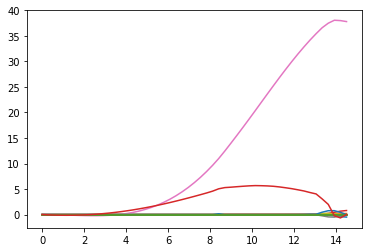

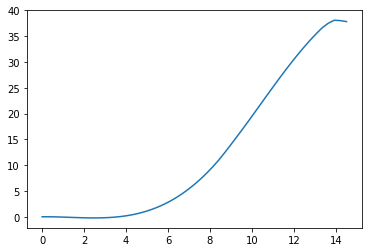

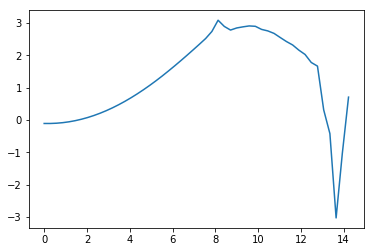

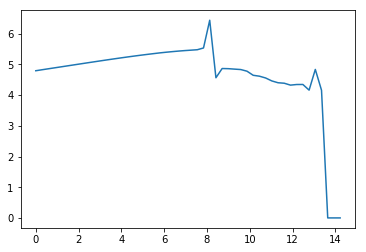

In [23]:
plt.plot(time_array, traj[:,:])
plt.show()
plt.plot(time_array, traj[:,6])
plt.show()
plt.plot(time_array[:-1], input_traj[:])
plt.show()
plt.plot(time_array[:-1], force_traj[:,3])
plt.show()

In [140]:
angle = 0.0
angle_vel = 0.0 # 5.0
current_state = (0.,0.0,angle,0.1,0.,0.,angle_vel,2.0)
vis.draw_transformation(current_state, dim=2)

In [139]:
# code to simulate dynamics
sec = 0.5 # seconds
steps_per_sec = 1000.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step
for t in np.linspace(0,sec,num_steps):
    torque = [0.0]
    force = [0.,5.,0.,0.,0.,0.,0.,0.]
    current_state += nd_cube_dynamics(current_state,2,torque,force)*sec_per_step
    vis.draw_transformation(current_state, dim=2)
    time.sleep(sec_per_step)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  
